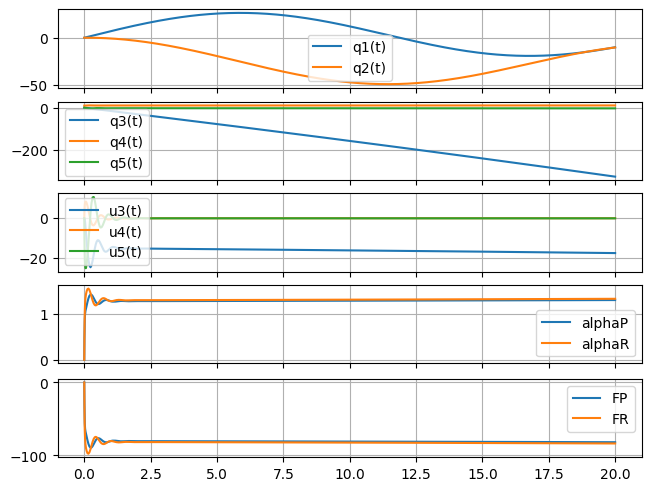

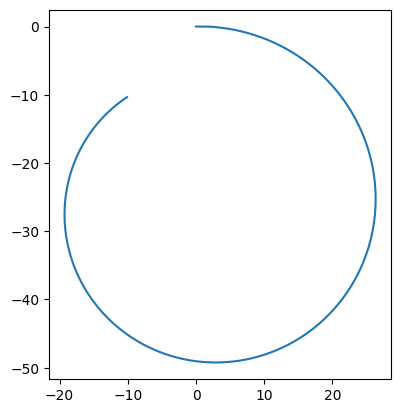

In [1]:
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# %%
# Specify the equations of motion
# -------------------------------
#
# The model is constructed using several constant parameters:
#
# - :math:`h`: distance mass center is from the ground contact line
# - :math:`a`: longitudinal distance of the mass center from the rear contact
# - :math:`b`: wheelbase length
# - :math:`g`: acceleration due to gravity
# - :math:`m`: mass of bicycle and rider
# - :math:`I_1`: roll principle moment of inertia
# - :math:`I_2`: pitch principle moment of inertia
# - :math:`I_3`: yaw principle moment of inertia
h, a, b, g = sm.symbols('h a, b, g', real=True)
m, I1, I2, I3 = sm.symbols('m, I1, I2, I3', real=True)
CaP, CaR = sm.symbols('CaP, CaR', real=True)

q1, q2, q3, q4, q5 = me.dynamicsymbols('q1, q2, q3, q4, q5', real=True)
u1, u2, u3, u4, u5 = me.dynamicsymbols('u1, u2, u3, u4, u5', real=True)
t = me.dynamicsymbols._t

q = sm.Matrix([q1, q2, q3, q4])
u = sm.Matrix([u1, u2, u3, u4])
p = sm.Matrix([h, a, b, g, m, I1, I2, I3, CaP, CaR])
r = sm.Matrix([q5, u5])

N, A, B, C = sm.symbols('N, A, B, C', cls=me.ReferenceFrame)
O, P, Q, R, S = sm.symbols('O, P, Q, R, S',  cls=me.Point)

A.orient_axis(N, q3, N.z)
B.orient_axis(A, q4, A.x)
C.orient_axis(A, q5, A.z)

P.set_pos(O, q1*N.x + q2*N.y)
Q.set_pos(P, a*A.x)
R.set_pos(P, b*A.x)
S.set_pos(Q, h*B.z)

A.set_ang_vel(N, u3*N.z)
B.set_ang_vel(A, u4*A.x)
C.set_ang_vel(A, u5*A.z)

O.set_vel(N, 0)
P.set_vel(N, u1*N.x + u2*N.y)
Q.v2pt_theory(P, N, A)
R.v2pt_theory(P, N, A)
S.v2pt_theory(Q, N, B)

IB = me.Inertia.from_inertia_scalars(S, B, I1, I2, I3)

bike_body = me.RigidBody('bike', S, B, m, IB)

alphaP = sm.atan(P.vel(N).dot(A.y) / P.vel(N).dot(A.x))
alphaR = sm.atan(R.vel(N).dot(C.y) / R.vel(N).dot(C.x))

gravity = me.Force(S, -m*g*N.z)
rear_tire = me.Force(P, -CaP*alphaP*A.y)
front_tire = me.Force(R, -CaR*alphaR*C.y)

kane = me.KanesMethod(
    N,
    (q1, q2, q3, q4),
    (u1, u2, u3, u4),
    kd_eqs=(u1 - q1.diff(t),
            u2 - q2.diff(t),
            u3 - q3.diff(t),
            u4 - q4.diff(t),)
)

kane.kanes_equations(bodies=(bike_body,),
                     loads=(gravity, front_tire, rear_tire))

eval_eom = sm.lambdify((q, u, r, p),
                       (kane.mass_matrix_full, kane.forcing_full))

eval_slip = sm.lambdify((q, u, r, p), (alphaP, alphaR))

target_roll_angle = np.deg2rad(10.0)
initial_speed = 7.0  # m/s


def control(t, q, u):
    gain = 3.0
    return np.array([gain*(target_roll_angle - q[3]), -gain*u[3]])


def rhs(t, x, p):
    q = x[0:4]
    u = x[4:8]
    r = control(t, q, u)
    M, F = eval_eom(q, u, r, p)
    return np.linalg.solve(M, F.squeeze())


x0 = np.array([
    0.0,
    0.0,
    0.0,
    target_roll_angle,  # q4 [rad]
    initial_speed,  # u1 [m/s]
    0.0,
    0.0,
    0.0,
])

p_vals = np.array([
    1.0,  # h [m]
    0.5,  # a [m]
    1.0,  # b [m]
    9.81,  # g [m/s^2]
    87.0,  # m [kg]
    9.2,  # I1 [kg m^2]
    11.0,  # I2 [kg m^2]
    2.8,  # I3 [kg m^2]
    3600.0,  # CaP, Fig 7.4 in Gabriele's thesis shows Ca=(100 N / 2 deg)
    3600.0,  # CaR
])




solution = solve_ivp(rhs, (0.0, 20.0), x0, args=(p_vals,))

qs = solution.y[0:4]
us = solution.y[4:8]
rs = control(solution.t, qs, us)
alphaPs, alphaRs = eval_slip(qs, us, rs, p_vals)
fig, axes = plt.subplots(5, 1, sharex=True, layout='constrained')
axes[0].plot(solution.t, qs[0:2].T)
axes[0].legend(q[0:2])
axes[0].grid()
axes[1].plot(solution.t, np.rad2deg(qs[2:4].T), solution.t, np.rad2deg(rs[0]))
axes[1].legend([q3, q4, q5])
axes[1].grid()
axes[2].plot(solution.t, np.rad2deg(us[2:4].T), solution.t, np.rad2deg(rs[1]))
axes[2].legend([u3, u4, u5])
axes[2].grid()
axes[3].plot(solution.t, np.rad2deg(alphaPs), solution.t, np.rad2deg(alphaRs))
axes[3].legend(['alphaP', 'alphaR'])
axes[3].grid()
axes[4].plot(solution.t, -p_vals[-2]*alphaPs,
             solution.t, -p_vals[-1]*alphaRs)
axes[4].legend(['FP', 'FR'])
axes[4].grid()

fig, ax = plt.subplots()
ax.plot(qs[0], qs[1])
ax.set_aspect('equal')


plt.show()



/var/folders/xv/s21tw0zj3njb0tc6nb87t33r0000gn/T/ipykernel_54946/209590899.py:30: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=0.8)


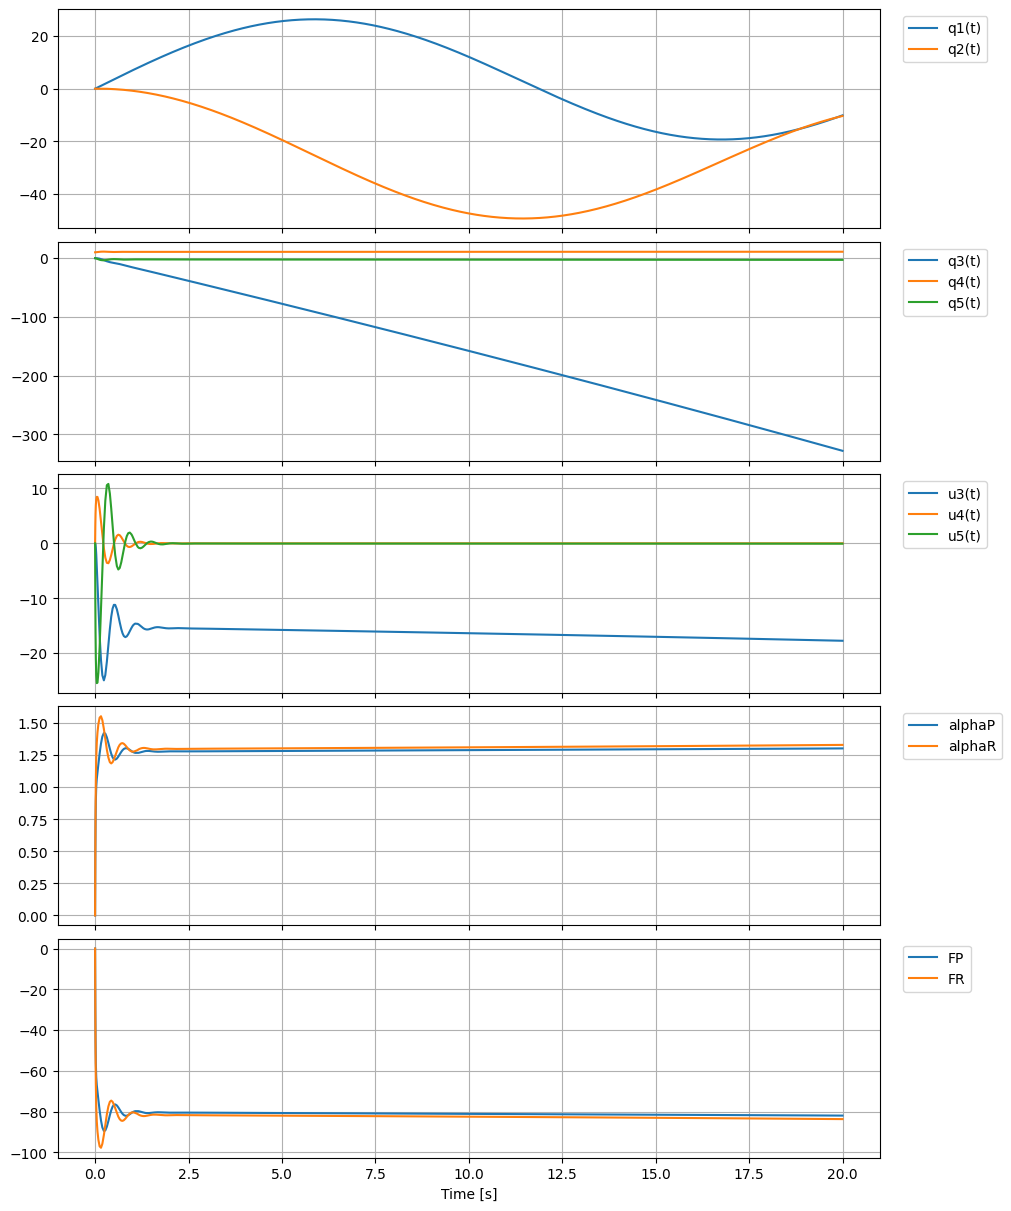

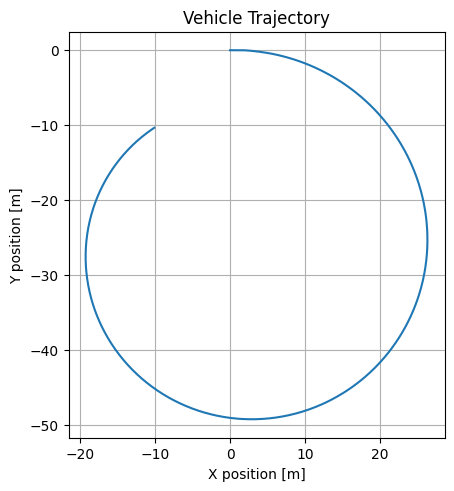

In [2]:


fig, axes = plt.subplots(5, 1, sharex=True, layout='constrained', figsize=(10, 12))

# Plot 1: Position states
axes[0].plot(solution.t, qs[0:2].T)
axes[0].legend(q[0:2], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].grid()

# Plot 2: Angles
axes[1].plot(solution.t, np.rad2deg(qs[2:4].T), solution.t, np.rad2deg(rs[0]))
axes[1].legend([q3, q4, q5], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].grid()

# Plot 3: Rates
axes[2].plot(solution.t, np.rad2deg(us[2:4].T), solution.t, np.rad2deg(rs[1]))
axes[2].legend([u3, u4, u5], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[2].grid()

# Plot 4: Slip angles
axes[3].plot(solution.t, np.rad2deg(alphaPs), solution.t, np.rad2deg(alphaRs))
axes[3].legend(['alphaP', 'alphaR'], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[3].grid()

# Plot 5: Tire forces
axes[4].plot(solution.t, -p_vals[-2]*alphaPs, solution.t, -p_vals[-1]*alphaRs)
axes[4].legend(['FP', 'FR'], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[4].grid()
axes[4].set_xlabel('Time [s]')

# Adjust subplot spacing to accommodate legends
plt.subplots_adjust(right=0.8)

# Trajectory plot
fig2, ax = plt.subplots(layout='constrained')
ax.plot(qs[0], qs[1])
ax.set_aspect('equal')
ax.set_xlabel('X position [m]')
ax.set_ylabel('Y position [m]')
ax.set_title('Vehicle Trajectory')
ax.grid(True)

plt.show()